# ODE Solver Multi-language Wrapper Package

The following benchmarks demonstrate the performance differences due to using similar algorithms from wrapper packages in the main scripting languages across a range of stiff and non-stiff ODEs. It takes into account solver time and error in order to ensure correctness of interpretations. These were ran with Julia 1.3, MATLAB 2019B, deSolve 1.2.5, and SciPy 1.3.1.

These benchmarks are generated using the following bindings:

**MATLABDiffEq.jl (MATLAB)**  (--> Unable to add package)

**SciPyDiffEq.jl (SciPy)**

**deSolveDiffEq.jl (deSolve)**  (--> Unable to using package)

**OrdinaryDiffEq.jl (OrdinaryDiffEq.jl)**

**Sundials.jl (Sundials)**

**ODEInterfaceDiffEq.jl (Hairer and Netlib)**

The respective repos verify negligible overhead on interop (MATLAB, ODEInterface, and Sundials overhead are negligable, SciPy is accelerated 3x over SciPy+Numba setups due to the Julia JIT on the ODE function, deSolve sees a 3x overhead over the pure-R version). Error and timing is compared together to ensure the methods are solving to the same accuracy when compared.

In [1]:
using ParameterizedFunctions, OrdinaryDiffEq, ODEInterface,
      ODEInterfaceDiffEq, Plots, Sundials, SciPyDiffEq, LSODA, ODE

In [2]:
using DiffEqDevTools
using LinearAlgebra
using DifferentialEquations

In [34]:
using IterableTables, DataFrames

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273


# Non-Stiff Problem 1: Lotka-Volterra

In [39]:
# Use plotly backend / or gr()
gr(size=(800,600))
# PyPlot.svg(true)

f = @ode_def_bare LotkaVolterra begin
  dx = a*x - b*x*y
  dy = -c*y + d*x*y
end a b c d
p = [1.5,1,3,1]
tspan = (0.0,10.0)
u0 = [1.0,1.0]
prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob,Vern7(),abstol=1/10^14,reltol=1/10^14)

df = DataFrame(sol)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.00241,1.00646,1.01186,1.01804,1.02547,1.03394,1.04363,1.0545
2,1.0,0.990509,0.975211,0.955982,0.935346,0.912293,0.887969,0.862346,0.83599


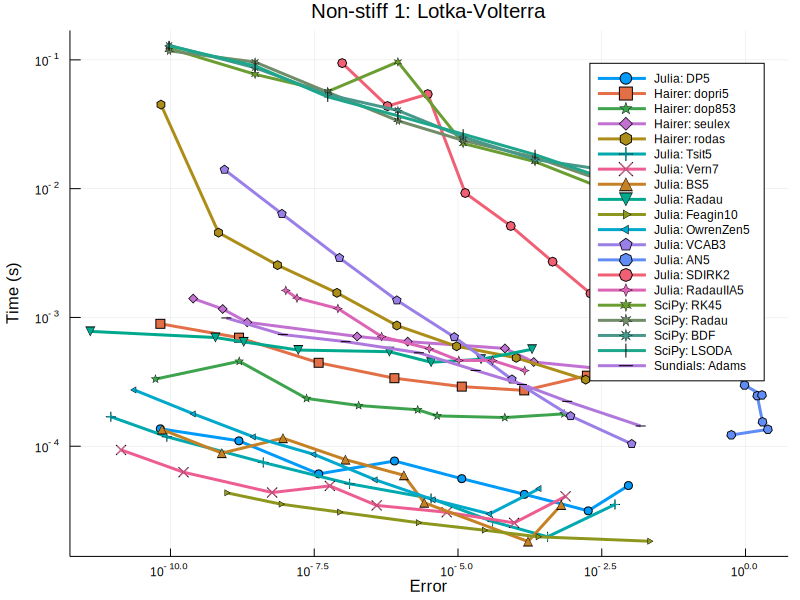

In [40]:
test_sol = TestSolution(sol)

setups = [
    Dict(:alg=>DP5())
    Dict(:alg=>dopri5())
    Dict(:alg=>dop853())
    Dict(:alg=>seulex())
    Dict(:alg=>rodas())
    Dict(:alg=>Tsit5())
    Dict(:alg=>Vern7())
    Dict(:alg=>BS5())
    Dict(:alg=>radau())
    Dict(:alg=>Feagin10())
    Dict(:alg=>OwrenZen5())
    Dict(:alg=>VCAB3())
    Dict(:alg=>AN5())
    Dict(:alg=>SDIRK2())
    Dict(:alg=>RadauIIA5())
    Dict(:alg=>SciPyDiffEq.RK45())
    Dict(:alg=>SciPyDiffEq.Radau())
    Dict(:alg=>SciPyDiffEq.BDF())
    Dict(:alg=>SciPyDiffEq.LSODA())
    Dict(:alg=>CVODE_Adams())
  ]

names = [
    "Julia: DP5"
    "Hairer: dopri5"
    "Hairer: dop853"
    "Hairer: seulex"
    "Hairer: rodas"
    "Julia: Tsit5"
    "Julia: Vern7"
    "Julia: BS5" 
    "Julia: Radau"
    "Julia: Feagin10"
    "Julia: OwrenZen5"
    "Julia: VCAB3"
    "Julia: AN5"
    "Julia: SDIRK2"
    "Julia: RadauIIA5"
    "SciPy: RK45"
    "SciPy: Radau"
    "SciPy: BDF"
    "SciPy: LSODA"
    "Sundials: Adams"
  ]

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names = names,
                      appxsol=test_sol,dense=false,
                      save_everystep=false,numruns=1,maxiters=100000,
                      timeseries_errors=false,verbose=false)
plot(wp,title="Non-stiff 1: Lotka-Volterra")
# savefig("ode_solver_wrapper_Problem1.svg")

# Non-Stiff Problem 2: Rigid Body

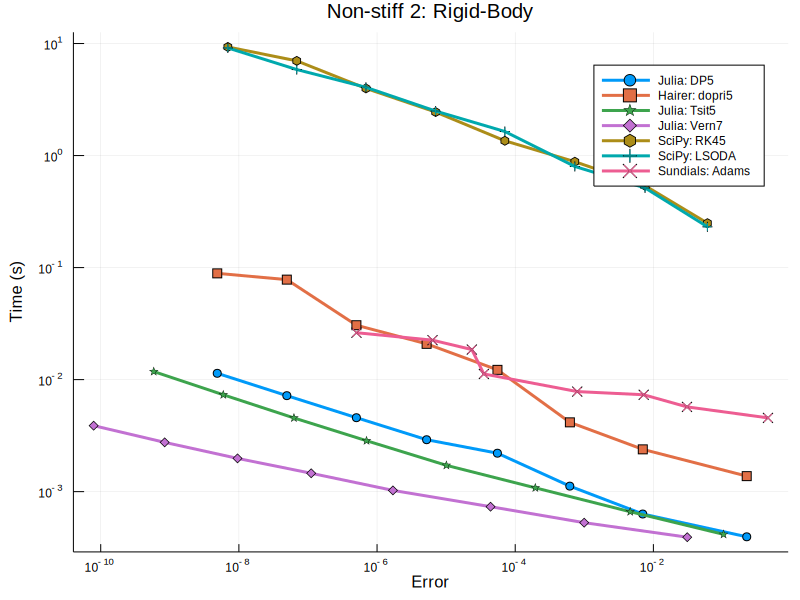

In [6]:
f = @ode_def_bare RigidBodyBench begin
  dy1  = -2*y2*y3
  dy2  = 1.25*y1*y3
  dy3  = -0.5*y1*y2 + 0.25*sin(t)^2
end
prob = ODEProblem(f,[1.0;0.0;0.9],(0.0,100.0))
sol = solve(prob,Vern7(),abstol=1/10^14,reltol=1/10^14)
test_sol = TestSolution(sol)

setups = [Dict(:alg=>DP5())
          Dict(:alg=>dopri5())
          Dict(:alg=>Tsit5())
          Dict(:alg=>Vern7())
          Dict(:alg=>SciPyDiffEq.RK45())
          Dict(:alg=>SciPyDiffEq.LSODA())
          Dict(:alg=>CVODE_Adams())
  ]

names = [
  "Julia: DP5"
  "Hairer: dopri5"
  "Julia: Tsit5"
  "Julia: Vern7"
  "SciPy: RK45"
  "SciPy: LSODA"
  "Sundials: Adams"
  ]

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names = names,
                      appxsol=test_sol,dense=false,
                      save_everystep=false,numruns=1,maxiters=100000,
                      timeseries_errors=false,verbose=false)
plot(wp,title="Non-stiff 2: Rigid-Body")
# savefig("ode_solver_wrapper_Problem2.png")

# Simulating the Oregonator ODE model

In [35]:
# https://www.radford.edu/~thompson/vodef90web/problems/demosnodislin/Demos_Pitagora/DemoOrego/demoorego.pdf

gr(size=(600,400))
function orego(du,u,p,t)
  s,q,w = p
  y1,y2,y3 = u
  du[1] = s*(y2+y1*(1-q*y1-y2))
  du[2] = (y3-(1+y1)*y2)/s
  du[3] = w*(y1-y3)
end
p = [77.27,8.375e-6,0.161]
y0 = [1.0,2.0,3.0]
tspan = (0.0,360.0)
prob = ODEProblem(orego,y0,tspan,p)
sol =  solve(prob,rodas(), alg_hints=[:stiff])

# DataFrames
df = DataFrame(sol)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.00008,1.00054,1.00332,1.01981,1.11322,1.51372,1.81218,1.94767
2,2.0,2.0,2.0,2.0,2.0,1.99998,1.99981,1.99943,1.99884
3,3.0,3.0,3.0,2.99999,2.99992,2.99951,2.99743,2.99483,2.99193


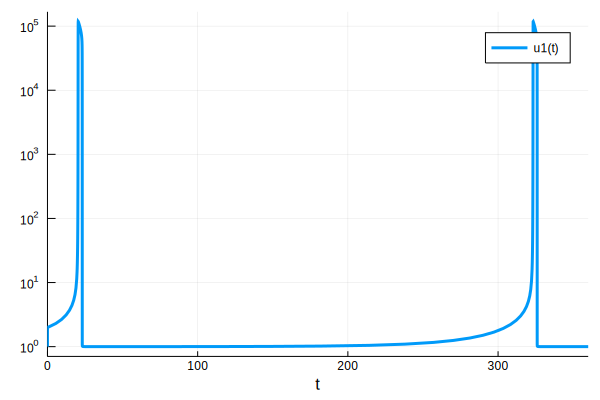

In [30]:
plot(sol, vars=[1], yaxis=:log)

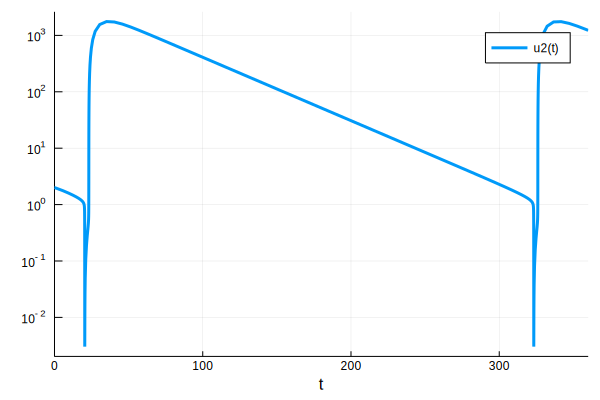

In [31]:
plot(sol, vars=[2], yaxis=:log)

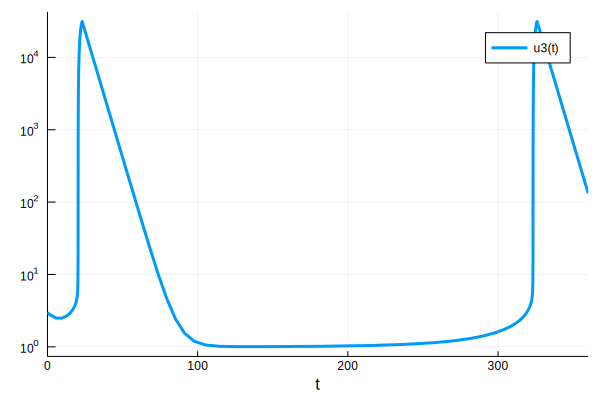

In [32]:
plot(sol, vars=[3], yaxis=:log)

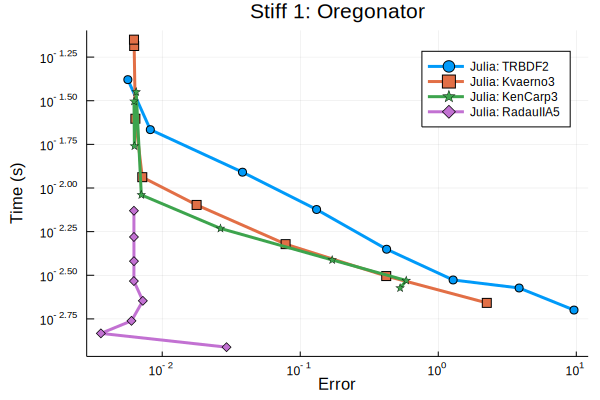

In [13]:
test_sol = TestSolution(sol)

setups = [Dict(:alg=>TRBDF2())
          Dict(:alg=>Kvaerno3())
          Dict(:alg=>KenCarp3())
          Dict(:alg=>RadauIIA5())
  ]

names = [
  "Julia: TRBDF2"
  "Julia: Kvaerno3"
  "Julia: KenCarp3"
  "Julia: RadauIIA5"
  ]

abstols = 1.0 ./ 10.0 .^ (6:13)
reltols = 1.0 ./ 10.0 .^ (3:10)
wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                      names = names,
                      appxsol=test_sol,dense=false,
                      save_everystep=false,numruns=1,maxiters=100000,
                      timeseries_errors=false,verbose=false)
plot(wp,title="Stiff 1: Oregonator")
# savefig("ode_solver_wrapper_Problem3.png")